# Wellcome Data Cleansing Project

This is a data-cleaning exercise for my thinkful Data Science Course
Raj Prasad, May 2019

## Tasks: 
* determine the five most common journals 
* determine the total articles for each of the above. 
* calculate the mean, median, and standard deviation of the open-access cost per article for each journal.
* (bonus) identify the open access prices paid by subject area.

(You will need to do considerable data cleaning in order to extract accurate estimates. You may may want to look into data encoding methods if you get stuck.)


## Import & Clean the Data

* I converted the given file to unicode 8 by opening it in Apple's Numbers application and saving it as unicode 8 (feels like cheating, but it worked.)
* I cleaned the cost column - removing '£' and punctution and converting to numeric
* I used ngrams, tfidf and cosine similarity to normalize the journal names

The last of these was more involved.  I followed the process defined [here](https://bergvca.github.io/2017/10/14/super-fast-string-matching.html) by Chris van den Berg.   

In [168]:
#imports, file load, and print header of raw data

#note that I converted the file to unicode8 with another utility

import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
%matplotlib inline

#import data from local file - assumed to be in same directory as this workbook
w = pd.read_csv('WELLCOME_APCspend2013_forThinkful2.csv')


In [169]:
#check to make sure the "." is in every cell...there is
#commented as the check is complete and need not be re-executed
# lbs_rows = [("." in x) for x in w["COST (£) charged to Wellcome (inc VAT when charged)"]]
# print(len(lbs_rows))


In [170]:
#a look at the starting table
w.head()

,PMID/PMCID,Publisher,Journal title,Article title,COST (£) charged to Wellcome (inc VAT when charged)
0,NaN,CUP,Psychological Medicine,Reduced parahippocampal cortical thickness in ...,£0.00
1,PMC3679557,ACS,Biomacromolecules,Structural characterization of a Model Gram-ne...,£2381.04
2,23043264 PMC3506128,ACS,J Med Chem,"Fumaroylamino-4,5-epoxymorphinans and related ...",£642.56
3,23438330 PMC3646402,ACS,J Med Chem,Orvinols with mixed kappa/mu opioid receptor a...,£669.64
4,23438216 PMC3601604,ACS,J Org Chem,Regioselective opening of myo-inositol orthoes...,£685.88


number of costs >100k is  0


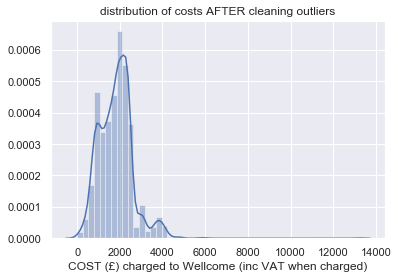

In [176]:
#clean the cost column

#check to make sure the "£" is in every cell...there is
#commented as the check is complete and need not be re-executed
# lbs_rows = [("£" in x) for x in w["COST (£) charged to Wellcome (inc VAT when charged)"]]
# print(len(lbs_rows)) 

#check to make sure the "." is in every cell...there is
#commented as the check is complete and need not be re-executed
# period_rows = [("." in x) for x in w["COST (£) charged to Wellcome (inc VAT when charged)"]]
# print(len(period_rows))

def clean_money(df, col):
    if isinstance(df[col][0], str): 
        df[col] = pd.to_numeric(
            df[col].str.strip('£').str.strip('$').str.replace(",", "")) 

clean_money(w, "COST (£) charged to Wellcome (inc VAT when charged)")

#clean up outlier costs - mostly '999999'
num_outliers = len(w[w["COST (£) charged to Wellcome (inc VAT when charged)"]>=100000])
print("number of costs >100k is ", num_outliers)

w = w[w["COST (£) charged to Wellcome (inc VAT when charged)"] < 100000]

sns.distplot(w["COST (£) charged to Wellcome (inc VAT when charged)"])
plt.title("distribution of costs AFTER cleaning outliers")
plt.show()


In [177]:
#Clean the journal title column
#There are around ~1k journal names, and many are likely mis / alternate spellings of the
#same journal name.  So I'm going to use TfId and cosine similarity normalize the names. 

import re
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import sparse_dot_topn.sparse_dot_topn as ct
from sparse_dot_topn import awesome_cossim_topn

def ngrams(string, n=3):
    string = re.sub(r'[,-./]|',r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

def get_matches_df(sparse_matrix, name_vector, top=100):
    non_zeros = sparse_matrix.nonzero()
    
    sparserows = non_zeros[0]
    sparsecols = non_zeros[1]
    
    if top:
        nr_matches = top
    else:
        nr_matches = sparsecols.size
    
    left_side = np.empty([nr_matches], dtype=object)
    right_side = np.empty([nr_matches], dtype=object)
    similarity = np.zeros(nr_matches)
    
    for index in range(0, nr_matches):
        left_side[index] = name_vector[sparserows[index]]
        right_side[index] = name_vector[sparsecols[index]]
        similarity[index] = sparse_matrix.data[index]
    
    return pd.DataFrame({'left_side': left_side,
                          'right_side': right_side,
                           'similarity': similarity})

w["Journal title"] = [str(i).lower() for i in (w["Journal title"])]
#create a list of unique journal names
journals = [str(i) for i in (w["Journal title"].sort_values().unique())]

#get the TfIdf matrix
vectorizer = TfidfVectorizer(min_df=1, analyzer=ngrams)
tf_idf_matrix = vectorizer.fit_transform(journals)

#get the most similar matches - I iterated and 80% seems to be a good cut-off
#for finding different names that are really the same journal
matches = awesome_cossim_topn(tf_idf_matrix, tf_idf_matrix.transpose(), 10, 0.80)
matches_df = get_matches_df(matches, journals, top=False)
matches_df = matches_df[matches_df['similarity'] < .99999999999999] # Remove all exact matches

#convert the matches table into a dictionary
s = set()
for index, row in matches_df.iterrows(): 
    s.add(tuple(set([row["left_side"], row["right_side"]])))

title_dict=dict()
title_dict = dict(s)

#create a new column with normalized journal titles
normalized_titles = []
for index, row in w.iterrows():
    curr_title = row["Journal title"]
    normalized_titles.append(title_dict.get(curr_title, curr_title))
w["Normalized Journal Title"] = normalized_titles


In [178]:
#Cleaned journal titles
w[w["Journal title"] != w["Normalized Journal Title"]].head()

,PMID/PMCID,Publisher,Journal title,Article title,COST (£) charged to Wellcome (inc VAT when charged),Normalized Journal Title
16,22610094,AMBSB,journal of biological chemistry,Annexin-1 interaction with FPR2/ALX,265.67,the journal of biological chemistry
25,23072351,American Chemical Society,analytical chemistry,Amphipathic polymers facilitate the study of f...,2082.74,current analytical chemistry
26,PMC3477822,American Chemical Society,analytical chemistry,Quantitative dynamics of phosphorproteome: the...,2314.10,current analytical chemistry
27,PMC3530960,American Chemical Society,analytical chemistry,Variable-Pitch Rectangular Cross-section Radio...,759.67,current analytical chemistry
31,PMID:23281892 PMC3579312,American Chemical Society,journal of medicinal chemistry,A class of 5-nitro-2-furancarboxylamides with ...,321.12,journal of medicinal chemistry


## Tasks

In [179]:
# Task 1: determine the five most common journals
w['Normalized Journal Title'].value_counts().head(5).index.to_list()

['plos one',
 'the journal of biological chemistry',
 'neuroimage',
 'nucleic acids research',
 'plos neglected tropical diseases']

In [180]:
# Task 2: get count of articles for top 5 journals
w['Normalized Journal Title'].value_counts().head(5)

plos one                               182
the journal of biological chemistry     60
neuroimage                              29
nucleic acids research                  26
plos neglected tropical diseases        23
Name: Normalized Journal Title, dtype: int64

In [181]:
# Task 3: calculate the mean, median, and sd 
# of the open-access cost per article for each journal.

#df.sort_values(by=('Labs', 'II'), ascending=False)
w.groupby("Normalized Journal Title").describe().reset_index().sort_values(by=("COST (£) charged to Wellcome (inc VAT when charged)", "count"), ascending=False)

summ_by_journal = w.groupby("Normalized Journal Title").describe().reset_index().sort_values(by="Normalized Journal Title", ascending=False)

summ_by_journal


Normalized Journal Title  \
                                                         
803                         zoonoses and public health   
802                                visual neuroscience   
801                                    vision research   
800                                     virus research   
799                                   virology journal   
798                                           virology   
797                                veterinary research   
796                                  veterinary record   
795                            veterinary parasitology   
794                            veterinary microbiology   
793                              vascular pharmacology   
792                                            vaccine   
791                                       urolithiasis   
790                                      urban history   
789                                       tuberculosis   
788         tropical medicine and international health   
787                tropical animal health & production   
786                                trop med int health   
785                                             trials   
784                             trends in parasitology   
783                             trends in neuroscience   
782                       trends in molecular medicine   
781                             trends in microbiology   
780                                 trends in genetics   
779                        trends in cognitive science   
778                           translational psychiatry   
777  transactions of the royal society of tropical ...   
776                                            traffic   
775                         tissue engineering: part a   
774                      ticks and tick-borne diseases   
..                                                 ...   
29                                         am j bioeth   
28             alimentrary pharmacology & therapeutics   
27                              alcohol and alcoholism   
26                                             aids uk   
25                           aids research and therapy   
24                                        aids journal   
23                                           aids care   
22                                          aids behav   
21                                                aids   
20                                          aging cell   
19                                    ageing & society   
18                                      age and ageing   
17                                                 age   
16       advances in experimental medicine and biology   
15                                           addiction   
14                                        acta physiol   
13                                 acta opthalmologica   
12                                    acta neuropathol   
11                                              acta f   
10                                  acta diabetologica   
9                           acta dermato venereologica   
8                                               acta d   
7                               acta crystallography d   
6                    acta crystallographica, section d   
5    acta crystallographica section f: structural b...   
4    acta crystallographica section d: biological c...   
3                                             acs nano   
2                            acs chemical neuroscience   
1                                 acs chemical biology   
0                   academy of nutrition and dietetics   

    COST (£) charged to Wellcome (inc VAT when charged)               \
                                                  count         mean   
803                                                1.0   2272.150000   
802                                                1.0   2034.000000   
801                                                1.0   1456.180000   
800            

In [182]:
print("total number of journal titles: ", len(w["Journal title"].unique()))
print("total number of normalized titles: ", len(w["Normalized Journal Title"].unique()))
print("set of matches length:  ", len(s))
print("dict of matches length:  ", len(title_dict))



total number of journal titles:  917
total number of normalized titles:  804
set of matches length:   207
dict of matches length:   162


In [183]:
from itertools import compress
# >>> list_a = [1, 2, 4, 6]
# >>> fil = [True, False, True, False]
# >>> list(compress(list_a, fil))

set(title_dict.keys()).intersection(set(title_dict.values()))
lower_titles = [x.lower() for x in title_dict.values()]
plos_titles_bool = [("plos" in x) for x in lower_titles]
plos_titles = list(compress(lower_titles, plos_titles_bool))
plos_titles


['plos neglected tropical diseases',
 'plos computational biology',
 'plos computational biology',
 'plos medicine journal',
 'plos neglected tropical diseases',
 'plos medicine']

In [184]:
#bonus task - average cost by topic area

from sklearn.cluster import KMeans

#use k-means to cluster the journal titles
num_clusters = 50 #k=50 seemed to give good semantic separation
km = KMeans(n_clusters=num_clusters)
%time km.fit(tf_idf_matrix)
clusters = km.labels_.tolist()

#add the cluster label to the dataset
cluster_dict = dict(zip(journals, clusters))
cluster_assignments = []
for index, row in w.iterrows():
    curr_title = row["Journal title"]
    cluster_assignments.append(cluster_dict.get(curr_title))
w["cluster"] = cluster_assignments

CPU times: user 8.34 s, sys: 720 ms, total: 9.06 s
Wall time: 4.99 s


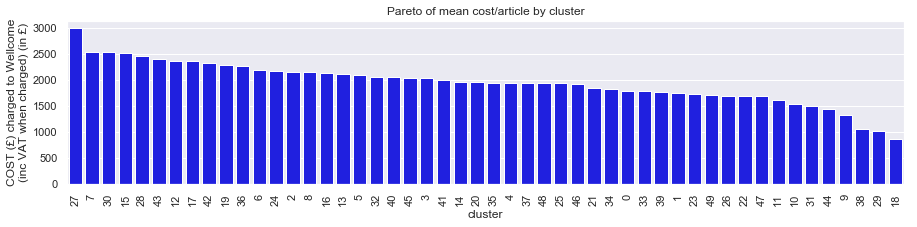

In [185]:
#get the average by cluster
cluster_costs = w[["COST (£) charged to Wellcome (inc VAT when charged)",
                  "cluster"]].groupby("cluster").mean().reset_index().\
                    sort_values(by="COST (£) charged to Wellcome (inc VAT when charged)", ascending=False)

sns.set()
plt.figure(figsize=(15, 3))
sns.barplot(x="cluster", y="COST (£) charged to Wellcome (inc VAT when charged)", data=cluster_costs, color="blue", order=cluster_costs.index)
plt.xticks(rotation=90)
plt.title("Pareto of mean cost/article by cluster")
plt.ylabel("COST (£) charged to Wellcome\n(inc VAT when charged) (in £)")
plt.show()

In [188]:
w[w.cluster==7]


,PMID/PMCID,Publisher,Journal title,Article title,COST (£) charged to Wellcome (inc VAT when charged),Normalized Journal Title,cluster
424,3564995,Dartmouth Journal Services,"g3: genes, genomes, genetics",How to design a genetic mating scheme: a basic...,1230.67,"g3: genes, genomes, genetics",7
450,Not yet available,Elsevier,applied energy,"Associations of individual, household and envi...",2377.65,applied energy,7
464,PMID: 23459248,Elsevier,biochimica et bioohysica acta - gene regulator...,The social fabric of the RNA degradosome,2476.42,biochimica et bioohysica acta - gene regulator...,7
579,PMC3688188,Elsevier,gene,Identification of multiple binding sites for t...,2406.10,gene,7
580,PMCID: PMC3611593,Elsevier,gene,Dissecting the mechanisms responsible for the ...,2445.23,gene,7
581,PMC3725413,Elsevier,gene,Identification of a SLC19A2 nonsense mutation ...,2468.74,gene,7
582,PMC3725417,Elsevier,gene therapy,"Gene therapy for PIDs: Progress, pitfalls and ...",2446.97,gene therapy,7
1035,Print not yet pub?,Nature,gene therapy,Inhibition of Neointimal Hyperplasia in a Rabb...,3000.00,gene therapy,7
1092,PMID: 23686316,Nature Publishing Group,oncogene,SATB1 collaborates with loss of p16 in cellula...,2774.45,oncogene,7
1093,PMID: 23708655,Nature Publishing Group,oncogene,Hox-mediated lmo2 expression in embryonic meso...,3360.00,oncogene,7
